In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/inventory-analysis-case-study/InvoicePurchases12312016.csv
/kaggle/input/inventory-analysis-case-study/EndInvFINAL12312016.csv
/kaggle/input/inventory-analysis-case-study/SalesFINAL12312016.csv
/kaggle/input/inventory-analysis-case-study/BegInvFINAL12312016.csv
/kaggle/input/inventory-analysis-case-study/2017PurchasePricesDec.csv
/kaggle/input/inventory-analysis-case-study/PurchasesFINAL12312016.csv


# Inventory Management

An optimal inventory management is a key factor to ensure both profitability and customer satisfaction; this is ensured by:
<ul>
    <li>Analyzing product sales performance.</li>
    <li>Defining the most efficient purchasing strategies.</li>
    <li>Minimizing waste by predicting optimal orders values.</li>
</ul>
Accordingly, this project will be organized in the following sections:
<ul>
    <li>In <em>Inventory Analysis</em> we take a general look at the data, studying the most/least requested product and the inventory stocks over time.</li>
    <li>In <em>Sales Analysis</em> we study the sales volume and its trend.</li>
    <li>In <em>Purchase Analysis</em> we take a look at purchases stats and the top vendors.</li>
    <li>In <em>Optimal Stock Level</em> we compute the optimal amount of each products to have in stock.</li>
    <li>In <em>Optimal Orders Calculation</em> we use the results of the previous section to compute the orders to place.</li>
</ul>

# Table of Contents
* [Setup](#setup)
    * [Loading libraries/useful functions](#code)
    * [Data prep](#dataprep)
    * [Missing values](#missval)
* [Inventory Analysis](#chp1)
    * [Inventory Summary - Top 10 stocks](#chp1_1)
        * [Beginning of the year](#chp1_1_1)
        * [End of the year](#chp1_1_2)
    * [Inventory Summary - Bottom 10 stocks](#chp1_2)
        * [Beginning of the year](#chp1_2_1)
        * [End of the year](#chp1_2_2)
    * [Time Stats](#chp1_3)
        * [Average Supply Time](#chp1_3_1)
        * [Average Payment Time](#chp_1_3_2)
* [Sales Analysis](#chp2)
    * [Best SellingProducts](#chp2_1)
    * [Slow Moving Products](#chp2_2)
    * [Sales Trends](#chp2_3)
* [Purchase Analysis](#chp3)
    * [Top 10 Vendors by Purchase Volume](#chp3_1)
    * [Top 10 Vendors by Purchase Cost](#chp3_2)
    * [Top 10 Vendors](#chp3_4)
* [Optimal Stock Level](#chp4)
    * [Sales Velocity](#chp4_1)
    * [Special Case: problematic products](#chp4_2)
* [Optimal Orders Calculation](#chp5)

## Setup <a name="setup"></a>

### Loading libraries/useful functions <a name="code"></a>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import sqlite3

In [3]:
def format_value(data, width: int, dec: str = ' ', end: str = '\n'):
    """
    Print text centered in a space of defined width.
    Args:
    data: the value to print
    width: the width of the full text to print.
    dec: a filler character to print in the eventual empty padding.
    end: a character at the end of the text.
    """
    text = str(data)
    if len(text) > width:
        text = text[:width]
    print(text.center(width, dec), end = end)

def title(text: str, dec: str = '*', width: int = 130):
    text = (' ' + text + ' ').upper()
    format_value(data = text, width = width, dec = dec)
    
def format_table(rows_data, headers, max_rows: int = 10, max_cols: int = 10, sep: str = '|', col_width: int = 15):
    """
    Print tabular data (i.e. the result of a SELECT query) to screen.
    Args:
    rows_data: iterable of data in the table
    headers: iterable with the names of the table columns
    max_rows: maximum number to rows to display.
    max_cols: maximum number to columns to display.
    sep: character used to separate columns.
    col_width: the number of character a column is wide.
    """
    rows_num = min(len(rows_data), max_rows)
    cols_num = min(len(headers), max_cols)
    for value in headers[:cols_num]:
        format_value(value, col_width, end = '|')
    print('\n', col_width * cols_num * '-', '\n')
    for i in range(rows_num):
        for value in rows_data[i][:cols_num]:
            format_value(value, col_width, end = '|')
        print('\n')

def get_query(query: str, conn):
    """
    Execute an SQL query and return the resulting data.
    Args:
    query: the query to use.
    conn: a connection to the database to query.
    Output:
    A tuple with the name of the table columns and the list with data values.
    """
    cur = conn.cursor()
    try:
        cur.execute(query)
        rows = cur.fetchall()
        cnames = list(map(lambda x: x[0], cur.description))
        return (cnames, rows)
    except Exception as e:
        print('Unable to query the database due to the following error: ', e)
    finally:
        cur.close()

def print_query(query: str, conn, max_rows: int = 10):
    """
    Print the results of an SQL query to screen.
    Args:
    query: the query to use.
    conn: a connection to the database to query.
    max_rows: the maximum number of rows to display.
    """
    cnames, rows = get_query(query = query, conn = conn)
    format_table(rows_data = rows, headers = cnames, max_rows = max_rows)


### Data prep <a name="dataprep"></a> 

In [4]:
purch_prices_dec_2017 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/2017PurchasePricesDec.csv')
beg_inv_final_2016 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/BegInvFINAL12312016.csv')
end_inv_final_2016 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/EndInvFINAL12312016.csv')
inv_purch_2016 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/InvoicePurchases12312016.csv')
purch_final_2016 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/PurchasesFINAL12312016.csv')
sales_final_2016 = pd.read_csv('/kaggle/input/inventory-analysis-case-study/SalesFINAL12312016.csv')

df_list = [
purch_prices_dec_2017,
beg_inv_final_2016,
end_inv_final_2016,
inv_purch_2016,
purch_final_2016,
sales_final_2016
]

Let's take a look at the data:

In [5]:
for df in df_list:
    df_name = [x for x in globals() if globals()[x] is df][0]
    title(df_name)
    display(df.head(3))

***************************************************** PURCH_PRICES_DEC_2017 ******************************************************


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP


******************************************************* BEG_INV_FINAL_2016 *******************************************************


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01


******************************************************* END_INV_FINAL_2016 *******************************************************


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2016-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2016-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2016-12-31


********************************************************* INV_PURCH_2016 *********************************************************


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,NaN
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,NaN
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,NaN


******************************************************** PURCH_FINAL_2016 ********************************************************


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1


******************************************************** SALES_FINAL_2016 ********************************************************


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY


We observe that sales_final_2016 has a date format different form the other tables, so we change it accordingly to be recognized by SQLite:

In [6]:
def format_date(x: str):
    date_vals = x.split('/')
    date_vals[0] = date_vals[0].rjust(2, '0') 
    date_vals[1] = date_vals[1].rjust(2, '0') 
    return ('-').join([date_vals[2], date_vals[0], date_vals[1]])
sales_final_2016['SalesDate'] = sales_final_2016['SalesDate'].map(lambda x : format_date(x))
sales_final_2016.head(10)

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375,1,0.79,12546,JIM BEAM BRANDS COMPANY
5,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,1,34.99,34.99,2016-01-15,375,1,0.39,12546,JIM BEAM BRANDS COMPANY
6,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,1,34.99,34.99,2016-01-22,375,1,0.39,12546,JIM BEAM BRANDS COMPANY
7,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,1,34.99,34.99,2016-01-30,375,1,0.39,12546,JIM BEAM BRANDS COMPANY
8,1_HARDERSFIELD_10058,1,10058,F Coppola Dmd Ivry Cab Svgn,750mL,4,59.96,14.99,2016-01-05,750,2,0.45,2000,SOUTHERN WINE & SPIRITS NE
9,1_HARDERSFIELD_10058,1,10058,F Coppola Dmd Ivry Cab Svgn,750mL,1,14.99,14.99,2016-01-06,750,2,0.11,2000,SOUTHERN WINE & SPIRITS NE


Finally we create an SQL database and convert pandas DataFrames into tables:

In [7]:
conn = sqlite3.connect('inventory')
purch_prices_dec_2017.to_sql('purch_prices', conn, if_exists = 'replace', index = False)
beg_inv_final_2016.to_sql('beg_inv', conn, if_exists = 'replace', index = False)
end_inv_final_2016.to_sql('end_inv', conn, if_exists = 'replace', index = False)
inv_purch_2016.to_sql('inv_purch', conn, if_exists = 'replace', index = False)
purch_final_2016.to_sql('purch_final', conn, if_exists = 'replace', index = False)
sales_final_2016.to_sql('sales_final', conn, if_exists = 'replace', index = False)

tables = [
    'purch_prices',
    'beg_inv',
    'end_inv',
    'inv_purch',
    'purch_final',
    'sales_final'
]

### Missing values <a name="missval"></a>

Incorrect data entries are an usual occurrence, especially when data is recored manually, missing values are among the most common example, although it's worth noting that their presence may be due to fields that were not applicable; to hadling missing values we therefore start with an analysis of their number and distribution:

In [8]:
for table in tables:
    q1 = f"SELECT * FROM {table} LIMIT 1"
    rows = get_query(q1, conn)
    cnames = rows[0]
    null_counts = []
    for cname in cnames:
        q2 = f"SELECT COUNT(1) FROM {table} WHERE {cname} IS NULL"
        q2_results = get_query(q2, conn)
        null_counts.append(q2_results[1][0][0])
    print(table.upper())
    no_null = True
    for c, v in zip(cnames, null_counts):
        if v != 0:
            no_null = False
            print(c, ': ', v)
    print('No data missing\n' if no_null else '\n')

PURCH_PRICES
Description :  1
Size :  1
Volume :  1


BEG_INV
No data missing

END_INV
City :  1284


INV_PURCH
Approval :  5169


PURCH_FINAL
Size :  3


SALES_FINAL
No data missing



We have three different situations:
<ul>
    <li>For <em>purch_prices</em> and <em>purch_final</em> the number of missing entries is negligible, so that we're satisfied to drop them (we could infer their values by using their mode, but we expect no better results).</li>
    <li>The <em>City</em> field of the <em>end_inv</em> table has too many missing values to just drop them, luckily for each store we can find at least one entry with non-null City field, therefore we can impute their values with no information loss.</li>
    <li>The <em>Approval</em> field in the <em>inv_purch</em> table has many missing values, but these may be interpreted as purchases with input status not yet decided, we decide to fill null values with "Unknown".</li>
</ul>

Cleaning the purchases tables is trivial:

In [9]:
q = """
DELETE FROM purch_prices WHERE ((Description IS NULL) OR (Size IS NULL) OR (Volume IS NULL));
DELETE FROM purch_final WHERE Size IS NULL;
"""

try:
    cur = conn.cursor()
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

We update the <em>inv_purch</em> table as explained above:

In [10]:
q = """
UPDATE inv_purch SET Approval = "Unknown" WHERE Approval IS NULL;
"""

try:
    cur = conn.cursor()
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

To fill <em>City</em> field of the <em>end_inv</em> table we'll join it with the distict <em>Store</em>-<em>City</em> pairs in <em>beg_inv</em>; however we notice how one store would be unaccounted for as shown below (the first entry is showed because it contains a NULL istance which is not recognised as common value): 

In [11]:
q = """
SELECT DISTINCT Store, City
FROM end_inv 
EXCEPT
SELECT DISTINCT Store, City
FROM beg_inv 
"""

print_query(q, conn)

     Store     |      City     |
 ------------------------------ 

       46      |      None     |

       81      |    PEMBROKE   |



The city for store 81 will therefore be updated separately:

In [12]:
q = """
DROP TABLE IF EXISTS end_inv_full;
CREATE TABLE IF NOT EXISTS end_inv_full AS 
WITH store_city AS 
(
SELECT DISTINCT beg_inv.Store, beg_inv.City
FROM beg_inv 
),
mini_end AS
(
SELECT end_inv.InventoryId, end_inv.Store, end_inv.Brand, end_inv.Description, end_inv.Size,
end_inv.onHand, end_inv.Price, end_inv.endDate
FROM end_inv
)
SELECT mini_end.*, store_city.City
FROM mini_end 
LEFT JOIN store_city 
ON mini_end.Store = store_city.Store;
UPDATE end_inv_full SET City = "PEMBROKE" WHERE Store = 81;
"""

try:
    cur = conn.cursor()
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()   

q = """
SELECT * FROM end_inv_full
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

  InventoryId  |     Store     |     Brand     |  Description  |      Size     |     onHand    |     Price     |    endDate    |      City     |
 --------------------------------------------------------------------------------------------------------------------------------------- 

1_HARDERSFIELD_|       1       |       58      |Gekkeikan Black|     750mL     |       11      |     12.99     |   2016-12-31  |  HARDERSFIELD |

1_HARDERSFIELD_|       1       |       62      |Herradura Silve|     750mL     |       7       |     36.99     |   2016-12-31  |  HARDERSFIELD |

1_HARDERSFIELD_|       1       |       63      |Herradura Repos|     750mL     |       7       |     38.99     |   2016-12-31  |  HARDERSFIELD |

1_HARDERSFIELD_|       1       |       72      |No. 3 London Dr|     750mL     |       4       |     34.99     |   2016-12-31  |  HARDERSFIELD |

1_HARDERSFIELD_|       1       |       75      |Three Olives To|     750mL     |       7       |     14.99     |   2016-12-31  |  HA

## Inventory Analysis <a name="chp1"></a> 

Before choosing sales strategies or make decisions about restocking it's essential to gain insight on the inventory data, this section is dedicated to answer some preliminary questions. 

### Inventory Summary - Top 10 stocks <a name="chp1_1"></a>

We start our inventory analysis by selecting the 10 largest stocks at the beginning and the end of the year:

#### Beginning of the year <a name="chp1_1_1"></a>

In [13]:
q = """
SELECT Brand, Description, SUM(onHand) as onHand 
FROM beg_inv 
GROUP BY Brand, Description
ORDER BY onHand DESC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  |     onHand    |
 --------------------------------------------- 

      4261     |Capt Morgan Spi|     15499     |

      8068     |Absolut 80 Proo|     15341     |

      3876     |Smirnoff 80 Pro|     14829     |

      3545     |Ketel One Vodka|     14499     |

      6879     |Maurice's Menth|     14180     |

      3858     |Grey Goose Vodk|     13649     |

      8111     |Smirnoff 80 Pro|     13521     |

      1233     |Jack Daniels No|     12016     |

      4243     |Bacardi Superio|     11640     |

      6570     |Kendall Jackson|     11586     |



#### End of the year <a name="chp1_1_2"></a>

In [14]:
q = """
SELECT Brand, Description, SUM(onHand) as onHand 
FROM end_inv_full 
GROUP BY Brand, Description
ORDER BY onHand DESC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  |     onHand    |
 --------------------------------------------- 

      3545     |Ketel One Vodka|     16770     |

      4261     |Capt Morgan Spi|     16769     |

      8111     |Smirnoff 80 Pro|     16242     |

      8068     |Absolut 80 Proo|     15608     |

      1233     |Jack Daniels No|     15047     |

      3102     |Smirnoff Travel|     14208     |

      5111     |Dr McGillicuddy|     13804     |

      1376     |    Jim Beam   |     13180     |

      6570     |Kendall Jackson|     13016     |

      1892     |   Yukon Jack  |     12764     |



**Outtakes:**
<ul>
    <li>Capt Morgan spice was in the first position at the beginning of the year and missed the top by just one unit at year-end, standing out as a strong seller.</li>
    <li>Ketel One Vodka jumped from 4th to 1st and Jack Daniels N. 7 Black jumped from 8th to 5th position, this could be caused by increasing demands or higher restocks during the year.</li>
    <li>Smirnoff 80 Proof changed its brand number, still remained consistently the 3rd product of choice. </li>
    <li>Absolut 80 proof dropped from 2nd to 4th position</li>
</ul>

### Inventory Summary - Bottom 10 stocks <a name="chp1_2"></a>

We repeat the same analysis for the bottom 10 stocks:

#### Beginning of the year <a name="chp1_2_1"></a>

In [15]:
q = """
SELECT Brand, Description, SUM(onHand) as onHand 
FROM beg_inv 
GROUP BY Brand, Description
ORDER BY onHand ASC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  |     onHand    |
 --------------------------------------------- 

      1044     |Dry Sack Sherry|       0       |

      1771     |Jack Daniels Te|       0       |

      1927     |Jack Daniels "B|       0       |

      1974     |Breaking & Ente|       0       |

      1982     |Herradura Silve|       0       |

      2230     |Egan's Single M|       0       |

      2715     |Teeling Single |       0       |

      2734     |Nikka Pure Malt|       0       |

      2963     |Bruichladdich T|       0       |

      2974     |Sazerac 6 Yr St|       0       |



#### End of the year <a name="chp1_2_2"></a>

In [16]:
q = """
SELECT Brand, Description, SUM(onHand) as onHand 
FROM end_inv_full 
GROUP BY Brand, Description
ORDER BY onHand ASC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  |     onHand    |
 --------------------------------------------- 

      319      |Peter Paul Baci|       0       |

      1044     |Dry Sack Sherry|       0       |

      1149     |Crown Royal Reg|       0       |

      1150     |Crown Royal Van|       0       |

      1152     |Captain Morgan |       0       |

      1157     |Bailey's Almand|       0       |

      1162     |Campeon Reposad|       0       |

      1163     |Absolut Lime Vo|       0       |

      1234     |Woodford Rsv Ma|       0       |

      2096     |The Macallan Ed|       0       |



**Outtakes:**
<ul>
    <li>All the items aren't in the inventory, which means that there were no stock throughout the year or that they were sold outand never replenished.</li>
    <li>The products listed are almost completely different between beginning and end of the year, suggesting fluctuations for low stock items.</li>
</ul>

### Time Stats <a name="chp1_3"></a>

We wish to retrieve some characteristic times associated with sales activity and inventory changes, to be precise the average time merch is supplied and the average time payment is processed:

#### Average Supply Time <a name="chp1_3_1"></a>

In [17]:
q = """
SELECT AVG(ReceivingDate - PODate) AS 'Average Supply Time (d)'
FROM 
(SELECT JULIANDAY(PODate) AS PODate, JULIANDAY(ReceivingDate) AS ReceivingDate 
FROM purch_final)
"""

print_query(q, conn)

Average Supply |
 --------------- 

7.6207371976306|



#### Average Payment Time <a name="chp1_3_2"></a>

In [18]:
q = """
SELECT AVG(PayDate - InvoiceDate) AS 'Average Payment Time (d)'
FROM 
(SELECT JULIANDAY(PayDate) AS PayDate, JULIANDAY(InvoiceDate) AS InvoiceDate 
FROM inv_purch)
"""

print_query(q, conn)

Average Payment|
 --------------- 

35.468518852606|



**Outtakes:**
<ul>
    <li>The average supply time is 7.6 days, indicating a quick turnaround after placing an order.</li>
    <li>The average payment time is 35.5 days, it would be advisable to clarify wether the vendor agreed on long credit terms, otherwise this could indicate a delay in payments. </li>
</ul>

## Sales Analysis <a name="chp2"></a>

Completed our first look to the inventory, we proceed to analyze the sales, checking in particular:
<ul>
    <li>which products were purchased the most.</li>
    <li>which products were purchased the least.</li>
    <li>if there's a meaningful pattern in sales through time. </li>
</ul>

### Best Selling Products <a name="chp2_1"></a>

In [19]:
q = """
SELECT Brand, Description, SUM(SalesQuantity) AS SalesQuantity
FROM sales_final 
GROUP BY Brand, Description
ORDER BY SalesQuantity DESC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  | SalesQuantity |
 --------------------------------------------- 

      8111     |Smirnoff 80 Pro|     28544     |

      1892     |   Yukon Jack  |     23121     |

      4261     |Capt Morgan Spi|     20226     |

      3606     |Smirnoff Raspbe|     19200     |

      5111     |Dr McGillicuddy|     18411     |

      3837     |   Skyy Vodka  |     14057     |

      4135     |Smirnoff Bluebe|     12477     |

      4157     |Smirnoff Green |     12102     |

      3545     |Ketel One Vodka|     11883     |

      8068     |Absolut 80 Proo|     11189     |



### Slow Moving Products <a name="chp2_2"></a>

In [20]:
q = """
SELECT Brand, Description, SUM(SalesQuantity) AS SalesQuantity
FROM sales_final 
GROUP BY Brand, Description
ORDER BY SalesQuantity ASC
LIMIT 10
"""

print_query(q, conn)

     Brand     |  Description  | SalesQuantity |
 --------------------------------------------- 

       86      |Don Julio Real |       1       |

      105      |Mr Boston Butte|       1       |

      129      |Grey Goose L'Or|       1       |

      143      |  Chivas Regal |       1       |

      148      |Smirnoff Green |       1       |

      150      |Smirnoff Strawb|       1       |

      151      |Pirassununga Ca|       1       |

      172      |Wild Turkey 101|       1       |

      204      |Smirnoff Pineap|       1       |

      248      |Wild Shot Repos|       1       |



### Sales Trends <a name="chp2_3"></a>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

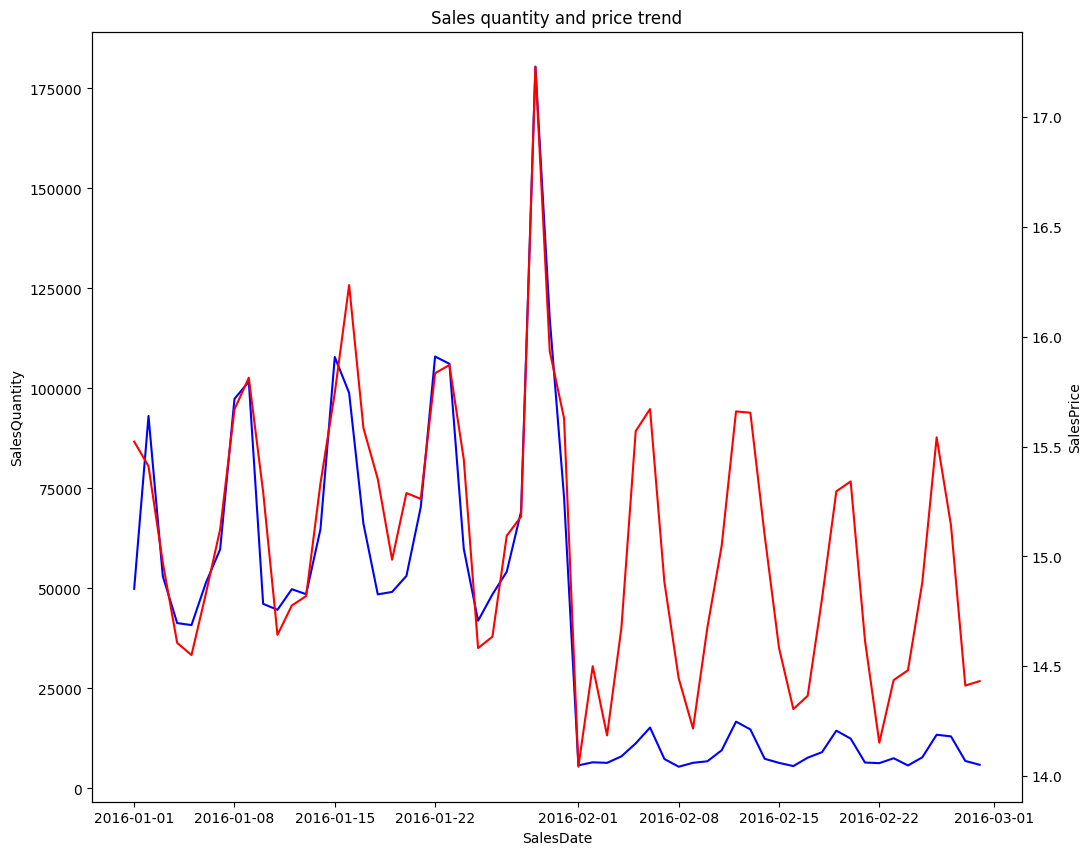

In [21]:
q = """
SELECT SalesDate, 
SUM(SalesQuantity) AS SalesQuantity,
AVG(SalesPrice) AS SalesPrice
FROM sales_final
GROUP BY SalesDate
"""

cnames, rows = get_query(q, conn)
sales_trend = pd.DataFrame(data = rows, columns = cnames)
sales_trend['SalesDate'] = pd.to_datetime(sales_trend['SalesDate'])
_, ax = plt.subplots(figsize = (12, 10))
sns.lineplot(data = sales_trend, x = 'SalesDate', y = 'SalesQuantity', color = 'blue', ax = ax)
ax2 = ax.twinx()
sns.lineplot(data = sales_trend, x = 'SalesDate', y = 'SalesPrice', color = 'red', ax = ax2)
ax.set_title('Sales quantity and price trend')
plt.show()

**Outtakes:**
<ul>
    <li>There's a cyclical pattern in the sales quantity as well as price.</li>
    <li>Both sales and price had a peak between January and February, then a sharp fall in the following weeks.</li>
</ul>

## Purchase Analysis <a name="chp3"></a>

We proceed to the analysis of purchases in order to identify the top vendors by volume of merch and by total cost:

### Top 10 vendors by purchase volumes <a name="chp3_1"></a>

In [22]:
q = """
SELECT 
VendorName, SUM(Quantity) AS Quantity
FROM inv_purch
GROUP BY VendorName
ORDER BY Quantity DESC
"""

print_query(q, conn)

   VendorName  |    Quantity   |
 ------------------------------ 

DIAGEO NORTH AM|    5459788    |

JIM BEAM BRANDS|    2737165    |

MARTIGNETTI COM|    2637275    |

CONSTELLATION B|    2325892    |

E & J GALLO WIN|    1858260    |

PERNOD RICARD U|    1647558    |

BACARDI USA INC|    1427075    |

SAZERAC CO INC |    1417727    |

M S WALKER INC |    1372841    |

ULTRA BEVERAGE |    1077527    |



### Top 10 Vendors by Purchase Cost <a name="chp3_2"></a>

In [23]:
q = """
SELECT 
VendorName, SUM(Dollars) AS Dollars
FROM inv_purch
GROUP BY VendorName
ORDER BY Quantity DESC
"""

print_query(q, conn)

   VendorName  |    Dollars    |
 ------------------------------ 

DIAGEO NORTH AM|50959796.849999|

MARTIGNETTI COM|27821473.909999|

JIM BEAM BRANDS|24203151.050000|

BACARDI USA INC|17624378.719999|

CONSTELLATION B|15573917.899999|

E & J GALLO WIN|12289608.089999|

M S WALKER INC |   10935817.3  |

SAZERAC CO INC |9916770.2599999|

ULTRA BEVERAGE |13210613.930000|

PERNOD RICARD U|  24124091.56  |



**Outtakes:**
<ul>
    <li>Diageo North America dominated as top vendor by both quantity as cost with a large margin.</li>
    <li>Martignetti Companies and Jim Beam Brands followed in 2nd and 3rd positions with more than 2 million in purchasing costs.</li>
</ul>

### Top 10 Vendors <a name="chp3_4"></a>

In [24]:
q = """
SELECT VendorName, SUM(PurchasePrice) AS Total_Purchases
FROM purch_prices 
GROUP BY VendorName
ORDER BY Total_Purchases DESC
"""

print_query(q, conn)

   VendorName  |Total_Purchases|
 ------------------------------ 

MARTIGNETTI COM|41619.920000000|

ULTRA BEVERAGE |33882.720000000|

PERFECTA WINES |30584.460000000|

SOUTHERN WINE &|18877.399999999|

M S WALKER INC |17710.679999999|

MOET HENNESSY U|    17505.36   |

DIAGEO NORTH AM|16162.679999999|

CAMPARI AMERICA|    16026.91   |

JIM BEAM BRANDS|    12091.69   |

EDRINGTON AMERI|    11453.53   |



## Optimal Stock Level <a name="chp4"></a>

The objective of this section is to compute the minimal amount of stocks products to satisfy the buyers' demand while not overbuying; we first calculate for each products the average and maximum daily sales:

### Sales velocity <a name="chp4_1"></a>

In [25]:
q = """
DROP VIEW IF EXISTS sales_velocity;
CREATE VIEW IF NOT EXISTS sales_velocity AS
WITH total_days AS
(
SELECT MAX(JULIANDAY(SalesDate)) - MIN(JULIANDAY(SalesDate)) AS TotalDays
FROM sales_final
)
SELECT sales_final.Brand, sales_final.Description, SUM(sales_final.SalesQuantity) AS TotalSales,
SUM(sales_final.SalesQuantity)/total_days.TotalDays AS SalesPerDay,
MAX(sales_final.SalesQuantity) AS MaxDailySales
FROM sales_final, total_days 
GROUP BY sales_final.Brand, sales_final.Description;
"""

try:
    cur = conn.cursor()
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()   

q = """
SELECT * FROM sales_velocity
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |   TotalSales  |  SalesPerDay  | MaxDailySales |
 --------------------------------------------------------------------------- 

       58      |Gekkeikan Black|      288      |4.8813559322033|       7       |

       60      |Canadian Club 1|      124      |2.1016949152542|       3       |

       61      |Margaritaville |       24      |0.4067796610169|       12      |

       62      |Herradura Silve|      162      |2.7457627118644|       3       |

       63      |Herradura Repos|      131      |2.2203389830508|       4       |

       72      |No. 3 London Dr|       19      |0.3220338983050|       3       |

       75      |Three Olives To|       3       |0.0508474576271|       1       |

       77      |Three Olives Es|      908      |15.389830508474|       8       |

       79      |Three Olives Lo|      416      |7.0508474576271|       5       |

       82      |Hundred Acre Ar|       3       |0.0508474576271|       3       |



We observe that some values of maximum daily sales are lower than the average: this can be due to outliers, data entry errors or computational errors and will be rectified later on.</br>
We then compute the average receiving time by product, <em>AvgLeadTime</em>:

In [26]:
q = """
DROP VIEW IF EXISTS purch_ltime;
CREATE VIEW IF NOT EXISTS purch_ltime AS
WITH purch_ld AS
(
SELECT *, JULIANDAY(ReceivingDate) - JULIANDAY(PODate) AS LeadTime
FROM purch_final
)
SELECT Brand, Description, AVG(LeadTime) AS AvgLeadTime 
FROM purch_ld
GROUP BY Brand, Description;
"""

cur = conn.cursor()
try:
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

q = """
SELECT * FROM purch_ltime
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |  AvgLeadTime  |
 --------------------------------------------- 

       58      |Gekkeikan Black|7.7583892617449|

       60      |Canadian Club 1|7.6597938144329|

       61      |Margaritaville |8.1153846153846|

       62      |Herradura Silve|7.3315696649029|

       63      |Herradura Repos|7.3244274809160|

       70      |Luxardo Amarett|7.3333333333333|

       72      |No. 3 London Dr|8.6363636363636|

       75      |Three Olives To|      7.0      |

       77      |Three Olives Es|7.2921615201900|

       79      |Three Olives Lo|7.2701612903225|



We finally are able to compute how much products units we should restock, we actually provide two suggestions:
<ul>
    <li>OptimalStockLevel (OSL): the minimum predicted stock level, chosen when it's preferred to minimize overbuying risk, and it's calculated by simply multiplying the average daily sales and lead time:</br> 
    
$OSL = SalesPerDay \times AvgLeadTime$   </li>
    <li>RecommendedStockLevel (RSL): when the priority is to ensure product availability we add to the OSL a margin, called <em>SafetyStock</em>, computed as the difference between the maximum and the average daily sales (if there'll be a spike in sales we assume it won't be greater than the maximum level ever encounterd before):</br>
$SafetyStock = (MaxDailySales - SalesPerDay)$</br>
$RSL = OSL + SafetyStock$</li>
</ul>

In [27]:
q = """
DROP TABLE IF EXISTS stocks_data;
CREATE TABLE IF NOT EXISTS stocks_data AS
WITH temp AS
(
SELECT sales_velocity.*,
sales_velocity.MaxDailySales - sales_velocity.SalesPerDay AS SafetyStock, 
purch_ltime.AvgLeadTime 
FROM sales_velocity LEFT JOIN purch_ltime 
ON sales_velocity.Brand = purch_ltime.Brand AND
sales_velocity.Description = purch_ltime.Description
)
SELECT *, 
ROUND(temp.SalesPerDay * temp.AvgLeadTime) AS OptimalStockLevel,
ROUND(temp.SalesPerDay * temp.AvgLeadTime) + temp.SafetyStock AS RecommendedStockLevel
FROM temp;
"""

cur = conn.cursor()
try:
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

q = """
SELECT * FROM stocks_data
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |   TotalSales  |  SalesPerDay  | MaxDailySales |  SafetyStock  |  AvgLeadTime  |OptimalStockLev|RecommendedStoc|
 --------------------------------------------------------------------------------------------------------------------------------------- 

       58      |Gekkeikan Black|      288      |4.8813559322033|       7       |2.1186440677966|7.7583892617449|      38.0     |40.118644067796|

       60      |Canadian Club 1|      124      |2.1016949152542|       3       |0.8983050847457|7.6597938144329|      16.0     |16.898305084745|

       61      |Margaritaville |       24      |0.4067796610169|       12      |11.593220338983|8.1153846153846|      3.0      |14.593220338983|

       62      |Herradura Silve|      162      |2.7457627118644|       3       |0.2542372881355|7.3315696649029|      20.0     |20.254237288135|

       63      |Herradura Repos|      131      |2.2203389830508|       4       |1.7796610169491|7.3244274809160|      16.0     |17.7

### Special case: problematic products <a name="chp4_1_1"></a>

We previously noted how in some entries <em>SalesPerDay</em> is incorrectly greater than <em>MaxDailySales</em>; this leads to misleading stock level, as immediately apparent by the negative amount of <em>SafetyStock</em> as shown below:

In [28]:
q = """
SELECT Brand, Description, SalesPerDay, MaxDailySales, SafetyStock 
FROM stocks_data
WHERE SalesPerDay > MaxDailySales
"""

print_query(q, conn)

     Brand     |  Description  |  SalesPerDay  | MaxDailySales |  SafetyStock  |
 --------------------------------------------------------------------------- 

       77      |Three Olives Es|15.389830508474|       8       |-7.389830508474|

       79      |Three Olives Lo|7.0508474576271|       5       |-2.050847457627|

      273      |Sauza Extra Gol|10.372881355932|       9       |-1.372881355932|

      482      |Absolut 80 Proo|37.135593220338|       23      |-14.13559322033|

      497      |Capt Morgan Spi|39.644067796610|       38      |-1.644067796610|

      597      |Baileys Irish C|      14.0     |       13      |      -1.0     |

      653      |Dom de Canton G|4.2881355932203|       4       |-0.288135593220|

      676      |Pinnacle Whippe|13.745762711864|       6       |-7.745762711864|

      811      |Jack Daniels No|30.322033898305|       26      |-4.322033898305|

      812      |Jagermeister Li|19.932203389830|       14      |-5.932203389830|



To correct the results from the entries where the average daily sales exceeded the maximum; without any additional information we impose some simple constraints:
<ul>
    <li>Set maximum daily sales equal to the average.</li>
    <li>Set SafetyStock equals to zero.</li>
    <li>Set the recommended stock level equal to the optimal stock level</li>
</ul>

In [29]:
q = """
UPDATE stocks_data 
SET MaxDailySales = SalesPerDay,
SafetyStock = 0,
RecommendedStockLevel = OptimalStockLevel
WHERE SalesPerDay > MaxDailySales;
"""

cur = conn.cursor()
try:
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

q = """
SELECT * FROM stocks_data
WHERE SafetyStock = 0
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |   TotalSales  |  SalesPerDay  | MaxDailySales |  SafetyStock  |  AvgLeadTime  |OptimalStockLev|RecommendedStoc|
 --------------------------------------------------------------------------------------------------------------------------------------- 

       77      |Three Olives Es|      908      |15.389830508474|15.389830508474|       0       |7.2921615201900|     112.0     |     112.0     |

       79      |Three Olives Lo|      416      |7.0508474576271|7.0508474576271|       0       |7.2701612903225|      51.0     |      51.0     |

      273      |Sauza Extra Gol|      612      |10.372881355932|10.372881355932|       0       |7.4981273408239|      78.0     |      78.0     |

      482      |Absolut 80 Proo|      2191     |37.135593220338|37.135593220338|       0       |7.4286321155480|     276.0     |     276.0     |

      497      |Capt Morgan Spi|      2339     |39.644067796610|39.644067796610|       0       |7.4407894736842|     295.0     |    

Let's visualize the recommended stock levels:

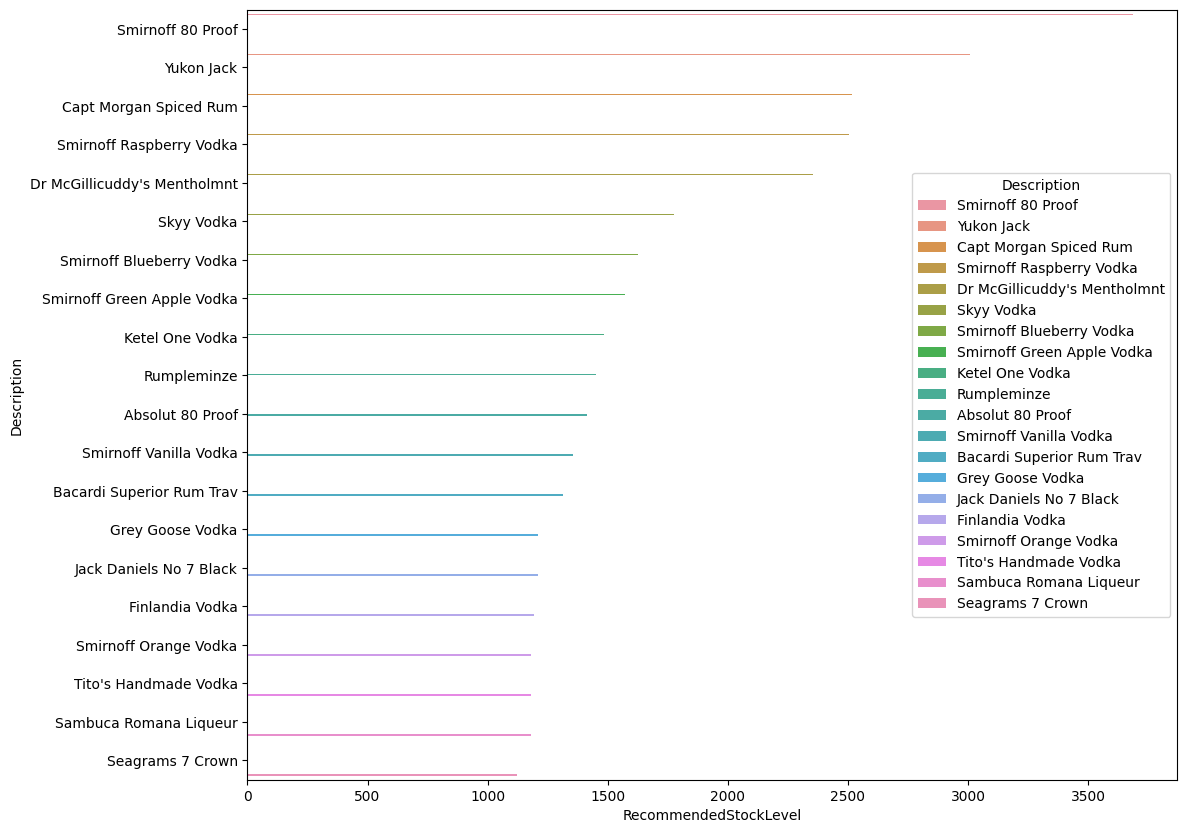

In [30]:
q = """
SELECT Description, RecommendedStockLevel
FROM stocks_data
ORDER BY RecommendedStockLevel DESC
LIMIT 20
"""

cnames, rows = get_query(q, conn)
top20_recommended_stock = pd.DataFrame(data = rows, columns = cnames)
_, ax = plt.subplots(figsize = (12, 10))
sns.barplot(data = top20_recommended_stock, x = 'RecommendedStockLevel', y = 'Description', hue = 'Description', ax = ax)
plt.show()

Studying the distribution of SafetyStock we observe than the vast majority of product has little to no need of a safety margin, making less of a difference between recommended and optimal stock levels:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


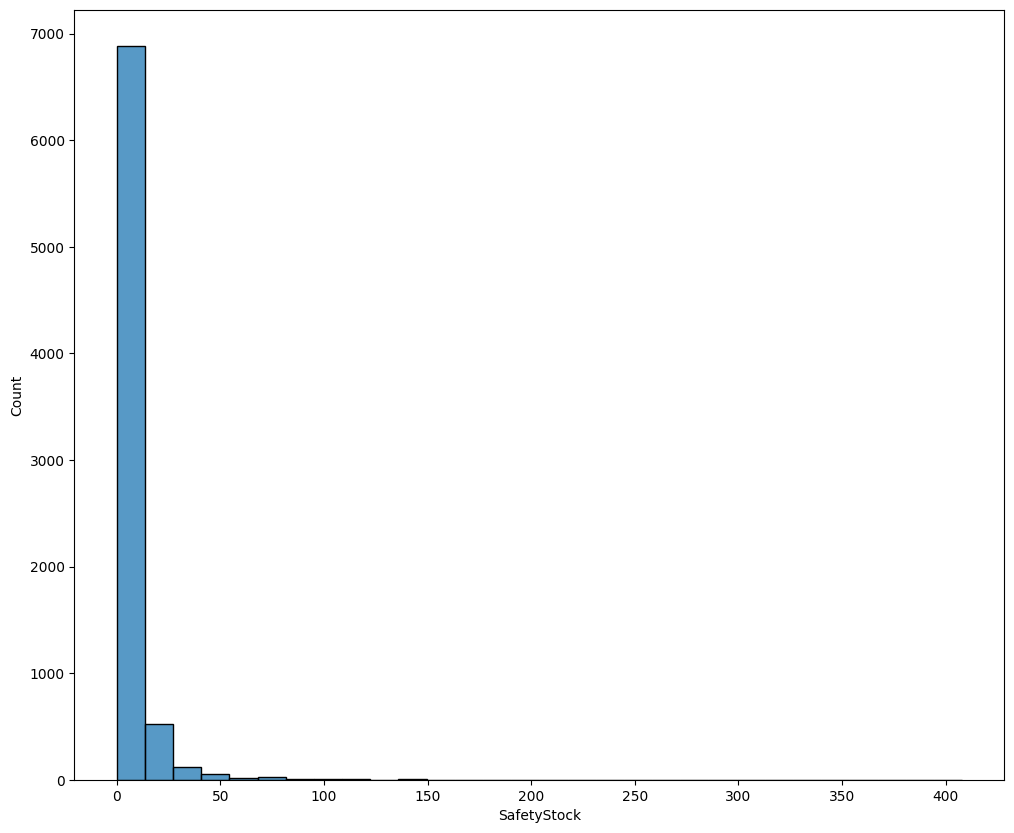

In [31]:
q = """
SELECT SafetyStock
FROM stocks_data
"""

cnames, rows = get_query(q, conn)
safety_stock = pd.DataFrame(data = rows, columns = cnames)
_, ax = plt.subplots(figsize = (12, 10))
sns.histplot(data = safety_stock, x = 'SafetyStock', bins = 30, ax = ax)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


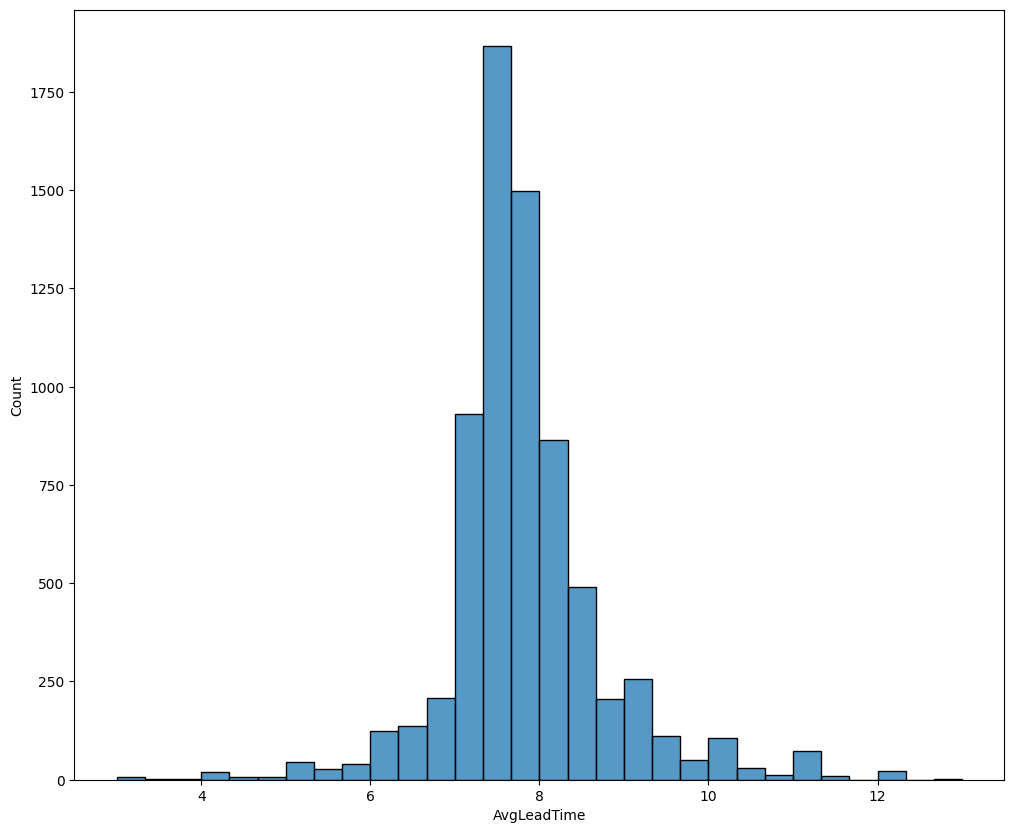

In [32]:
q = """
SELECT AvgLeadTime
FROM stocks_data
"""

cnames, rows = get_query(q, conn)
safety_stock = pd.DataFrame(data = rows, columns = cnames)
_, ax = plt.subplots(figsize = (12, 10))
sns.histplot(data = safety_stock, x = 'AvgLeadTime', bins = 30, ax = ax)
plt.show()

## Optimal orders calculation <a name="chp5"></a>

Once the desired stock level is computed (we'll use the <em>RecommendedStockLevel</em> in this example), we can calculate the orders to place to replenish our inventory accordingly; we first check how many units of each product we have "currently", that is at the last date in the inventory data:

In [33]:
q = """
DROP TABLE IF EXISTS stocks_orders;
CREATE TABLE IF NOT EXISTS stocks_orders AS
WITH max_date AS
(
SELECT MAX(JULIANDAY(endDate)) AS MaxEndDate 
FROM end_inv_full
),
current_stock AS
(
SELECT end_inv_full.Brand, end_inv_full.Description, SUM(end_inv_full.onHand) AS CurrentStock, max_date.MaxEndDate
FROM end_inv_full, max_date
WHERE JULIANDAY(end_inv_full.endDate) = max_date.MaxEndDate
GROUP BY end_inv_full.Brand, end_inv_full.Description
)
SELECT stocks_data.*, current_stock.CurrentStock 
FROM stocks_data JOIN current_stock 
ON stocks_data.Brand = current_stock.Brand AND
stocks_data.Description = current_stock.Description;
"""

cur = conn.cursor()
try:
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

q = """
SELECT * FROM stocks_orders
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |   TotalSales  |  SalesPerDay  | MaxDailySales |  SafetyStock  |  AvgLeadTime  |OptimalStockLev|RecommendedStoc|  CurrentStock |
 ------------------------------------------------------------------------------------------------------------------------------------------------------ 

       58      |Gekkeikan Black|      288      |4.8813559322033|       7       |2.1186440677966|7.7583892617449|      38.0     |40.118644067796|      385      |

       60      |Canadian Club 1|      124      |2.1016949152542|       3       |0.8983050847457|7.6597938144329|      16.0     |16.898305084745|      146      |

       61      |Margaritaville |       24      |0.4067796610169|       12      |11.593220338983|8.1153846153846|      3.0      |14.593220338983|       12      |

       62      |Herradura Silve|      162      |2.7457627118644|       3       |0.2542372881355|7.3315696649029|      20.0     |20.254237288135|      459      |

       63      |Herradura Repos|     

In [34]:
q = """
SELECT * FROM stocks_orders
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    print(cnames)
    #format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

['Brand', 'Description', 'TotalSales', 'SalesPerDay', 'MaxDailySales', 'SafetyStock', 'AvgLeadTime', 'OptimalStockLevel', 'RecommendedStockLevel', 'CurrentStock']


Then we simply define our orders as the difference between the recommended stock level and the current one:

In [35]:
q = """
UPDATE stocks_orders SET CurrentStock = 0 WHERE CurrentStock IS NULL;
ALTER TABLE stocks_orders ADD COLUMN OrderQuantity REAL;
UPDATE stocks_orders SET OrderQuantity = IIF(RecommendedStockLevel - CurrentStock > 0, RecommendedStockLevel - CurrentStock, 0);
"""

cur = conn.cursor()
try:
    cur.executescript(q)
    conn.commit()
except Exception as e:
    print('Unable to commit due to the following error: ', e)
finally:
    cur.close()

q = """
SELECT Brand, Description, CurrentStock, RecommendedStockLevel, OrderQuantity
FROM stocks_orders
ORDER BY OrderQuantity DESC
"""

cur = conn.cursor()
try:
    cur.execute(q)
    rows = cur.fetchall()
    cnames = list(map(lambda x: x[0], cur.description))
    format_table(rows_data = rows, headers = cnames)
except Exception as e:
    print('Unable to query the database due to the following error: ', e)
finally:
    cur.close()

     Brand     |  Description  |  CurrentStock |RecommendedStoc| OrderQuantity |
 --------------------------------------------------------------------------- 

      4227     |Bacardi Superio|      397      |     1312.0    |     915.0     |

     36380     |Sebastiani Znfd|       6       |     539.0     |     533.0     |

      4903     |Bacardi Superio|       8       |499.52542372881|491.52542372881|

      2792     | Jim Beam Apple|       53      |456.30508474576|403.30508474576|

      3783     |Ciroc Apple Vod|       7       |     356.0     |     349.0     |

      3300     |Smirnoff Sorbet|       55      |     399.0     |     344.0     |

      2704     |Serpent's Bite |      116      |431.01694915254|315.01694915254|

      5390     |Dr McGillicuddy|       0       |     223.0     |     223.0     |

      6432     |Shady Fruit Rea|       40      |252.40677966101|212.40677966101|

     19121     |Liberty School |       14      |     210.0     |     196.0     |

